In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L,get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds


In [2]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [3]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))


ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.075, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, -0.09, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, 0.09, 50))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

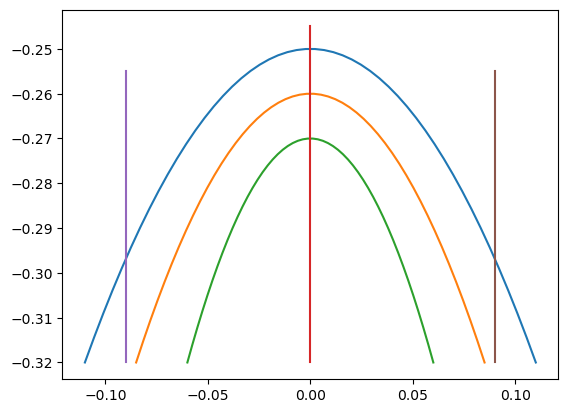

In [4]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

#plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [5]:
topology_index = 0
gm = get_preset_by_index_with_bounds(topology_index)
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

population_size = 32
n_generations = 20

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=actuator)

saver = ProblemSaver(problem, f"first_setup\\topology_{topology_index}", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       32 |      1 |             - |             -
     2 |       64 |      3 |  1.0000000000 |         ideal
     3 |       96 |      4 |  0.3364923973 |         ideal
     4 |      128 |      4 |  0.3087577673 |         ideal
     5 |      160 |      7 |  0.1266375523 |             f
     6 |      192 |     10 |  0.0293836009 |             f
     7 |      224 |      9 |  0.0246127763 |             f
     8 |      256 |     10 |  0.0106910138 |             f
     9 |      288 |      8 |  0.0316321114 |             f
    10 |      320 |      7 |  0.0099580105 |             f
    11 |      352 |     10 |  0.2150651749 |         ideal
    12 |      384 |     12 |  0.0680788403 |         ideal
    13 |      416 |     12 |  0.000000E+00 |             f
    14 |      448 |     14 |  0.0006858180 |             f
    15 |      480 |     15 |  0.0310218686 |         ideal
    16 |      512 |     17 |  0.0156009696 |            

In [7]:
sf = problem.soft_constrain
# builder = problem.builder
# crag = problem.rewards_and_trajectories.crag


counter = 0
for i, x in enumerate(res.X):
    x= np.round(x, 5)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter += 1
    else:
        __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
        print(res.F[i], vector_rewards)
counter

[-1.57411436 -1.85117144] [1.5741143623987834, 1.8511714410781954]
[-1.20049449 -3.75670392] [1.2004944880803425, 3.756703921196691]
[-1.50547071 -2.23810021] [1.5054707129796345, 2.238100214827177]
[-1.4635423  -2.49213737] [1.4635423024495442, 2.492137371002838]
[-1.4367791  -2.67809453] [1.4367791016896565, 2.6780945264752343]
[-1.42414661 -2.86948333] [1.4241466124852498, 2.8694833311408963]
[-1.38860051 -3.11447937] [1.388600508371989, 3.1144793672873]
[-1.62150482 -1.33995442] [1.621504823366801, 1.3399544201862792]
[-1.437392   -2.67160444] [1.437391996383667, 2.671604437239402]
[-1.20049322 -3.75671594] [1.2004932165145874, 3.7567159360470996]
[-1.4393754  -2.64467207] [1.439375400543213, 2.6446720738308906]
[-1.46192304 -2.61589106] [1.4619230429331462, 2.6158910559506934]
[-0.93779123 -4.37289024] [0.9377912282943726, 4.372890243347858]
[-1.60642823 -1.56395793] [1.6064282258351643, 1.5639579336106288]
[-1.11749516 -3.96448701] [1.1174951593081157, 3.9644870097480065]
[-1.348

0